### Plot zonal-mean zonal wind speed

In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

In [2]:
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.model import um
from aeolus.plot import subplot_label_generator

In [3]:
from util_commons import PLANETS, ROSE_SUITES

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
iris.FUTURE.datum_support = True
rcParams["mathtext.default"] = "regular"

In [5]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [6]:
planet = "wasp96b"
path_to_project = Path.home() / "projects" / planet
t0 = -20  # last 200 days
tgt_plevs = np.logspace(7, 2, 65)  # target pressure levels

In [7]:
vrbls = {}
for exp in ["equilibrium", "kinetics"]:
    vrbls[exp] = {}
    for mdh in ["mdh_0", "mdh_1"]:
        vrbls[exp][mdh] = {}
        for tK in ["tK_1", "tK_6"]:
            vrbls[exp][mdh][tK] = {}
            try:
                # Load variables
                fpath = ROSE_SUITES[planet][exp][mdh][tK]["dir_for_data"] / "merged"
                fname = f"{ROSE_SUITES[planet][exp][mdh][tK]['rose_suite']}.nc"
                u = iris.load_cube(fpath / fname, um.u)[t0:, ...]
                pres = iris.load_cube(fpath / fname, um.pres)[t0:, ...]
                lats_coord = u.coord("latitude")
                # Interpolate u wind speed to pressure levels
                u_plevs = interp_cube_from_height_to_pressure_levels(u, pres, tgt_plevs)
                pres_coord = u_plevs.coord("air_pressure")
                # Calculate zonal-mean zonal wind speed
                u_plevs_znl_mean = u_plevs.collapsed(["time", "longitude"], iris.analysis.MEAN)
                u_plevs_znl_mean.convert_units("km s-1")
                # Assemble data
                vrbls[exp][mdh][tK] = {
                    "u_plevs_znl_mean": u_plevs_znl_mean,
                }
            except OSError:  # mdh=1 tK=1 data is on DiRAC only
                pass

In [8]:
# Print max zonal-mean zonal (superrotating) wind speed
for exp in ["equilibrium", "kinetics"]:
    for mdh in ["mdh_0", "mdh_1"]:
        for tK in ["tK_1", "tK_6"]:
            try:
                print(
                    planet,
                    exp[0:3],
                    mdh,
                    tK,
                    vrbls[exp][mdh][tK]["u_plevs_znl_mean"]
                    .data[vrbls[exp][mdh][tK]["u_plevs_znl_mean"].data > 0]
                    .max(),
                )
            except KeyError:
                pass

wasp96b equ mdh_0 tK_1 5.455766041859508
wasp96b equ mdh_0 tK_6 5.0737326904810365
wasp96b equ mdh_1 tK_6 5.642817091857944
wasp96b kin mdh_0 tK_1 5.281508024069584
wasp96b kin mdh_0 tK_6 4.9041010882884715
wasp96b kin mdh_1 tK_6 5.16114822663674


In [9]:
# Average between equilibrium and kinetics simulations with mdh_0 tK_6
(5.0737326904810365 + 4.9041010882884715) / 2

4.988916889384754

In [10]:
# mdh_1 tK_6
(5.642817091857944 + 5.16114822663674) / 2

5.401982659247342

In [11]:
# Print max zonal-mean zonal (retrograge) wind speed
for exp in ["equilibrium", "kinetics"]:
    for mdh in ["mdh_0", "mdh_1"]:
        for tK in ["tK_1", "tK_6"]:
            try:
                print(
                    planet,
                    exp[0:3],
                    mdh,
                    tK,
                    vrbls[exp][mdh][tK]["u_plevs_znl_mean"]
                    .data[vrbls[exp][mdh][tK]["u_plevs_znl_mean"].data < 0]
                    .min(),
                )
            except KeyError:
                pass

wasp96b equ mdh_0 tK_1 -0.7468752922187281
wasp96b equ mdh_0 tK_6 -0.34286458808842923
wasp96b equ mdh_1 tK_6 -0.44597687651580054
wasp96b kin mdh_0 tK_1 -0.6033088567938314
wasp96b kin mdh_0 tK_6 -0.2700470470928551
wasp96b kin mdh_1 tK_6 -0.43722514513536526


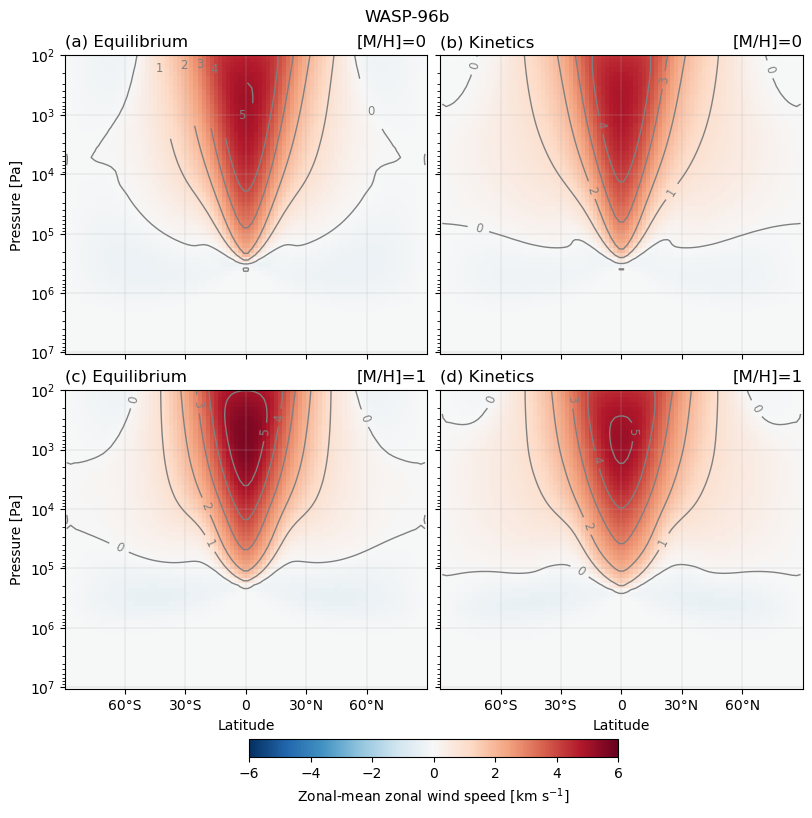

In [15]:
# Plot simulations with weak polar filtering (tK=6) only
tK = "tK_6"
fig, axs = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8, 8),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)
axs[0, 0].invert_yaxis()
iletters = subplot_label_generator()
for mdh, axrow in zip(["mdh_0", "mdh_1"], axs):
    for exp, ax in zip(["equilibrium", "kinetics"], axrow):
        u_plevs_znl_mean = vrbls[exp][mdh][tK]["u_plevs_znl_mean"]
        p0 = ax.pcolormesh(
            lats_coord.points,
            pres_coord.points,
            u_plevs_znl_mean.data,
            norm=MidpointNormalize(vmin=-6, vcenter=0, vmax=6),
            cmap="RdBu_r",
            shading="auto",
            rasterized=True,
        )
        p1 = ax.contour(
            lats_coord.points,
            pres_coord.points,
            u_plevs_znl_mean.data,
            levels=np.arange(-2, 6, 1),
            colors="grey",
            linewidths=1,
        )
        ax.clabel(p1, p1.levels, inline=True, fmt="%.0f", fontsize="small")
        # Common
        ax.set_title(f"({next(iletters)}) {exp.capitalize()}", loc="left")
        ax.set_title(f"[M/H]={mdh[-1]}", loc="right")
        ax.set_xticks([-60, -30, 0, 30, 60])
        ax.set_xticklabels(["60°S", "30°S", "0", "30°N", "60°N"])
        ax.set_yscale("log")
        ax.grid(lw=0.2)
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Latitude")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Pressure [Pa]")
fig.colorbar(
    p0,
    ax=axs,
    label="Zonal-mean zonal wind speed [km $s^{-1}$]",
    orientation="horizontal",
    shrink=0.5,
    pad=0.01,
)
fig.suptitle(f"{PLANETS[planet]['tex']}")
figname_png = f"{planet}_pres_u_znl_mean.png"
figname_pdf = f"{planet}_pres_u_znl_mean.pdf"
fig.savefig(path_to_project / "circulation" / "cross_section_znl_mean" / figname_png, dpi=300)
fig.savefig(
    path_to_project / "circulation" / "cross_section_znl_mean" / figname_pdf,
    format="pdf",
    bbox_inches="tight",
)

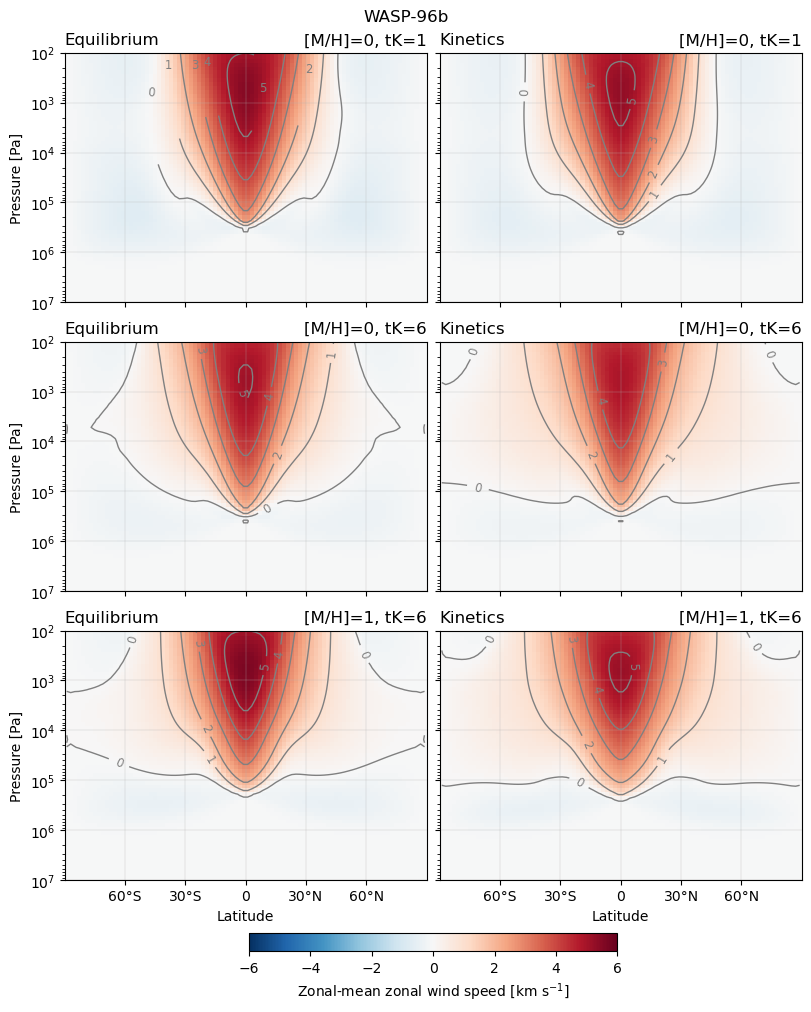

In [14]:
# Plot 6 simulations where the flow is prograde
fig = plt.figure(
    figsize=(8, 10),
    constrained_layout=True,
)
mosaic = [
    [f"{exp}_mdh_0_tK_1" for exp in vrbls.keys()],
    [f"{exp}_mdh_0_tK_6" for exp in vrbls.keys()],
    [f"{exp}_mdh_1_tK_6" for exp in vrbls.keys()],
]
axd = fig.subplot_mosaic(
    mosaic,
    sharex=True,
    sharey=True,
)
for exp in ["equilibrium", "kinetics"]:
    for mdh in ["mdh_0", "mdh_1"]:
        for tK in ["tK_1", "tK_6"]:
            if tK == "tK_1" and mdh == "mdh_1":
                continue
            ax = axd[f"{exp}_{mdh}_{tK}"]
            u_plevs_znl_mean = vrbls[exp][mdh][tK]["u_plevs_znl_mean"]
            p0 = ax.pcolormesh(
                lats_coord.points,
                pres_coord.points,
                u_plevs_znl_mean.data,
                norm=MidpointNormalize(vmin=-6, vcenter=0, vmax=6),
                cmap="RdBu_r",
                shading="auto",
                rasterized=True,
            )
            p1 = ax.contour(
                lats_coord.points,
                pres_coord.points,
                u_plevs_znl_mean.data,
                levels=np.arange(-2, 8, 1),
                colors="grey",
                linewidths=1,
            )
            ax.clabel(p1, p1.levels, inline=True, fmt="%.0f", fontsize="small")
            # Common
            ax.set_title(f"{exp.capitalize()}", loc="left")
            ax.set_title(f"[M/H]={mdh[-1]}, tK={tK[-1]}", loc="right")
            ax.set_xticks([-60, -30, 0, 30, 60])
            ax.set_xticklabels(["60°S", "30°S", "0", "30°N", "60°N"])
            ax.set_yscale("log")
            ax.set_ylim(1e7, 1e2)
            ax.grid(lw=0.2)
            if ax.get_subplotspec().is_last_row():
                ax.set_xlabel("Latitude")
            if ax.get_subplotspec().is_first_col():
                ax.set_ylabel("Pressure [Pa]")
fig.colorbar(
    p0,
    ax=[*axd.values()],
    label="Zonal-mean zonal wind speed [km $s^{-1}$]",
    orientation="horizontal",
    shrink=0.5,
    pad=0.01,
)
fig.suptitle(f"{PLANETS[planet]['tex']}")
figname = f"{planet}_pres_u_znl_mean_6sims.png"
fig.savefig(path_to_project / "circulation" / "cross_section_znl_mean" / figname, dpi=300)